# Specimage module for Myelin Raman data
## 2016.10.10 saved MCR results from joint images

First, we have to import a few modules. Notice that we also add the path to where we can find the **specimage** module before importing it. For more info, see notebook from 20161005

In [2]:
%load_ext autoreload
%autoreload 2
import sys
# change next line to the directory where you have the specimage.py file
sys.path.append('/home/leo/Academic/Projects/150-savvy/060.python')
from specimage import *
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import rpy2.robjects, rpy2.robjects.numpy2ri # read Rdata objects from R 

In the previous notebook (20160906) we joined all images, removed noisy pixels and estimated the MCR endmembers over the region 800~1800 under 4 models: 3 or 4 components, with or without closure. 

In [3]:
path = "/home/leo/Academic/Projects/150-savvy/050.received_data/201609.MyelinRaman/"
# the MCR file was created with b.find_endmember_abundance_MCR(); first list element is abundance
fl = gzip.open(path+"mcr_estim_3_closure.gz", "r");   em_3c = np.array(pickle.load(fl)[1]); fl.close()
fl = gzip.open(path+"mcr_estim_3_noclosure.gz", "r"); em_3n = np.array(pickle.load(fl)[1]); fl.close()
fl = gzip.open(path+"mcr_estim_4_closure.gz", "r");   em_4c = np.array(pickle.load(fl)[1]); fl.close()
fl = gzip.open(path+"mcr_estim_4_noclosure.gz", "r"); em_4n = np.array(pickle.load(fl)[1]); fl.close()
fl = gzip.open(path+"mcr_wl.gz", "r"); em_wl = np.array(pickle.load(fl)[0]); fl.close()
# "fine" means that 1. the interpolation was finer (i.e. using 100% of points), and 
# 2. initial MCR state was randomized
fl = gzip.open(path+"mcr_estim_4fine.gz", "r"); em_4f = np.array(pickle.load(fl)[1]); fl.close()
fl = gzip.open(path+"mcr_wl_fine.gz", "r"); em_wl_fine = np.array(pickle.load(fl)[0]); fl.close()

The MCR components below were estimated using a larger wave length region (from 700 to 1900), but the non-myelin spectrum seems less resolved (plots below).

In [4]:
fl = gzip.open(path+"mcr_estim_4_n_long.gz", "r"); em_4nl = np.array(pickle.load(fl)[1]); fl.close()
fl = gzip.open(path+"mcr_wl_long.gz", "r"); em_wl_l = np.array(pickle.load(fl)[0]); fl.close()
print (em_4nl.shape)

valid=[i for i in range(len(em_wl_l)) if (em_wl_l[i] > 800) and (em_wl_l[i] < 1800)]
em_wl_l = em_wl_l[valid]
em_4nl= em_4nl[:,valid]
print (em_4nl.shape)

(4, 468)
(4, 390)


Now we plot all results to see agreement between them.

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


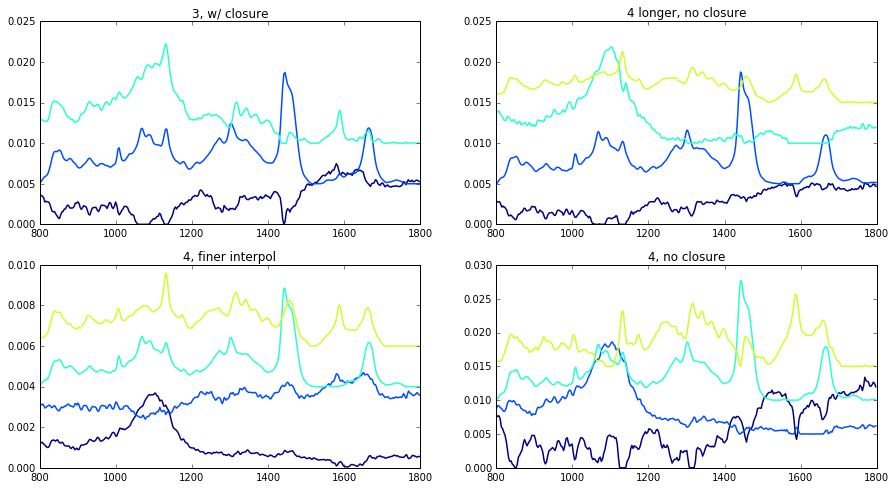

In [5]:
fig, axes = plt.subplots(2,2) ; fig.set_size_inches(15, 8)
em_list = [em_3c, em_4nl, em_4f, em_4n] ## 3 and 4 components and NO closure is the same as with closure
wl_list = [em_wl, em_wl_l, em_wl_fine, em_wl]
multipl = [5,5,2,5] # since MCR w/out closure and random initial state has distinct scaling
namelist=["3, w/ closure", "4 longer, no closure", "4, finer interpol", "4, no closure"]
for j in range(4):
    this_em = em_list[j]
    for i in range(this_em.shape[0]):
        axs = axes[j/2,j%2]
        axs.plot(wl_list[j], 0.001 * multipl[j]*i +  this_em[i], linewidth=1.5, c=plt.cm.jet(float(i)/5.))
        axs.set_title(namelist[j])

It seems that 4 components are needed to find the non-myelin cell bodies. The plot below is just to check difference between 4 component analyses, and it seems that 4n and 4c are better. (The longer wl region or the randomized initial state gave non-myelin distinct from the Matlab results)

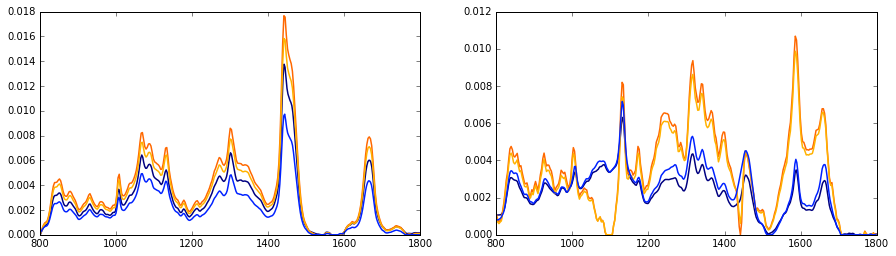

In [6]:
fig, axes = plt.subplots(1,2) ; fig.set_size_inches(15, 4)
axes[0].plot(em_wl_l, em_4nl[1], linewidth=1.5, c=plt.cm.jet(float(0)/5.))
axes[0].plot(em_wl, em_4n[2], linewidth=1.5, c=plt.cm.jet(float(4)/5.))
axes[0].plot(em_wl, em_4c[2], linewidth=1.5, c=plt.cm.jet(float(3.6)/5.))
axes[0].plot(em_wl_fine, 2 * em_4f[2], linewidth=1.5, c=plt.cm.jet(float(0.8)/5.))

axes[1].plot(em_wl_l, em_4nl[3], linewidth=1.5, c=plt.cm.jet(float(0)/5.))
axes[1].plot(em_wl, em_4n[3], linewidth=1.5, c=plt.cm.jet(float(4)/5.))
axes[1].plot(em_wl, em_4c[3], linewidth=1.5, c=plt.cm.jet(float(3.6)/5.))
axes[1].plot(em_wl_fine, 2 * em_4f[3], linewidth=1.5, c=plt.cm.jet(float(0.8)/5.))

Now we are ready to read the Matlab file into the specimage object (see previous notebook for more detailed info)

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:44: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


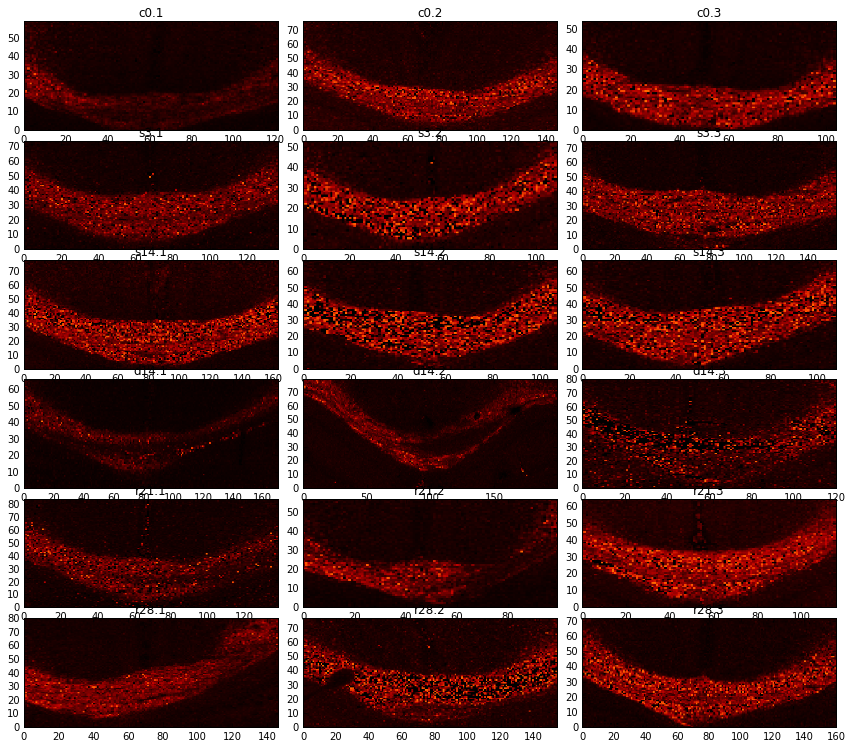

In [86]:
wl_axis = np.array([thisline.rstrip() for thisline in open(path + "02.wl_axis.txt")],dtype=float)
pairfiles = [re.split('\s+',thisline.rstrip()) for thisline in open(path + "02.file_shape.txt")]
files = [[x[0]+".Rdata",x[1]+"LEFT.Rdata", x[1]+"RIGHT.Rdata"] for x in pairfiles]

fig, axes = plt.subplots(6,3) ; fig.set_size_inches(12, 10)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.1)
RMI = list(range(len(pairfiles))) # initial list with dummy values
for f_idx in range(len(pairfiles)):
#for f_idx in range(3):
    # read each file into a specimage object
    rpy2.robjects.r['load'](path+pairfiles[f_idx][0]+".Rdata")
    y=rpy2.robjects.numpy2ri.ri2py(rpy2.robjects.r['x'])
    a=SpecImage()
    a.wl = wl_axis # from file with wavelength numbers
    a.description = pairfiles[f_idx][0]
    n_y = y.shape[0]; n_x = y.shape[1]
    a.xy = np.array([[i,j] for i in range(n_x) for j in range(n_y)],dtype=float)
    a.spc = np.array([y[j,i] for i in range(n_x) for j in range(n_y)],dtype=float)
    a.idx = np.arange(n_y * n_x)
    # preprocessing 
    a.set_wavelength_interval(800,1800)
    a.interpolate_spline(frac=1.)
    a.rescale_sum()
    # rescale endmembers to this wavelengths
    endmembers = np.array([np.interp(a.wl, em_wl, row) for row in em_4n],dtype=float)
    abund, endm, resid = a.find_abundance_maps(endmembers=endmembers)
    
    # reading mask files
    rpy2.robjects.r['load'](path+pairfiles[f_idx][1]+"LEFT.Rdata")
    y=rpy2.robjects.numpy2ri.ri2py(rpy2.robjects.r['x'])
    n_y = y.shape[0]; n_x = y.shape[1]
    mask = np.array([y[j,i] for i in range(n_x) for j in range(n_y)],dtype=int) # boolean list (0 or 255)
    rpy2.robjects.r['load'](path+pairfiles[f_idx][1]+"RIGHT.Rdata")
    y=rpy2.robjects.numpy2ri.ri2py(rpy2.robjects.r['x'])
    n_y = y.shape[0]; n_x = y.shape[1]
    mask += np.array([y[j,i] for i in range(n_x) for j in range(n_y)],dtype=int) # sum of left and right masks
    valid = [i for i, x in enumerate(mask) if x] # index of non-zero elements
    #   # another mask, of non-noise pixels
    non_noise, noise = a.remove_noisy_pixels(find_only=True)
    valid = sorted(set(non_noise) & set(valid)) # in hindsight, valid[] already have only non-noisy
    RMI[f_idx] = abund[valid,2]/(abund[valid,3]+0.001)
    
    # plotting (2 = myelin and 3=non-myelin)
    axs = axes[f_idx/3,f_idx%3]
    rmi =  abund[:,2]/(abund[:,3]+0.001); ## for ALL pixels, not only masked
    rmi[ np.where(rmi>10)[0] ] = 0
    rmi[noise] = 0
    Z, ext = create_grid_imshow(a.xy, rmi, resolution=400)
    im = axs.imshow(Z,extent=ext, aspect='auto', cmap=plt.get_cmap("gist_heat"), vmin=0, vmax=14)
    axs.set_title(pairfiles[f_idx][0])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


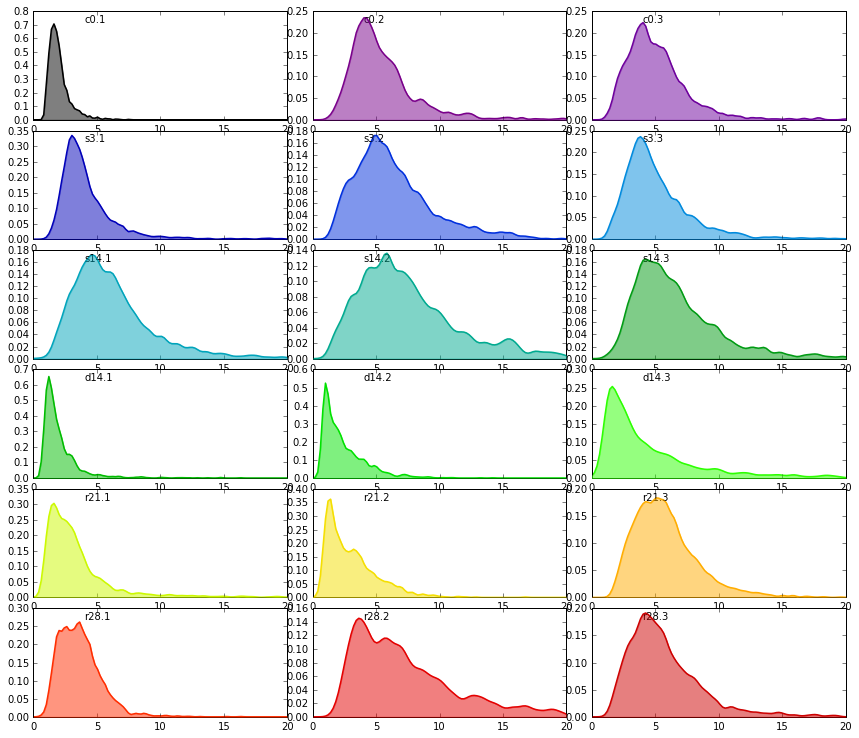

In [59]:
from scipy.stats import gaussian_kde # http://milkbox.net/note/gaussian-kde-smoothed-histograms-with-matplotlib/

fig, axes = plt.subplots(6,3) ; fig.set_size_inches(12, 10)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.1)

for i in range(len(pairfiles)):
    vals = RMI[i][RMI[i]<20]
    density = gaussian_kde(vals)
    density.covariance_factor = lambda : .1 # set the covariance_factor, lower means more detail
    density._compute_covariance()
    #dx = np.linspace(0., np.percentile(vals,q=99),100)
    dx = np.linspace(0., 20., 100)
    dy = density(dx)
    axs = axes[i/3,i%3]
    axs.plot(dx, dy, linewidth=1.5, c=plt.cm.spectral(float(i)/18.))
    axs.fill_between(dx, dy, alpha=.5, zorder=5, antialiased=True, color=plt.cm.spectral(float(i)/18.))
    axs.text(0.2,0.9,pairfiles[i][0], fontsize=10, transform=axs.transAxes)
    axs.ticklabel_format(axis='x', style='sci', scilimits=(-3,3))

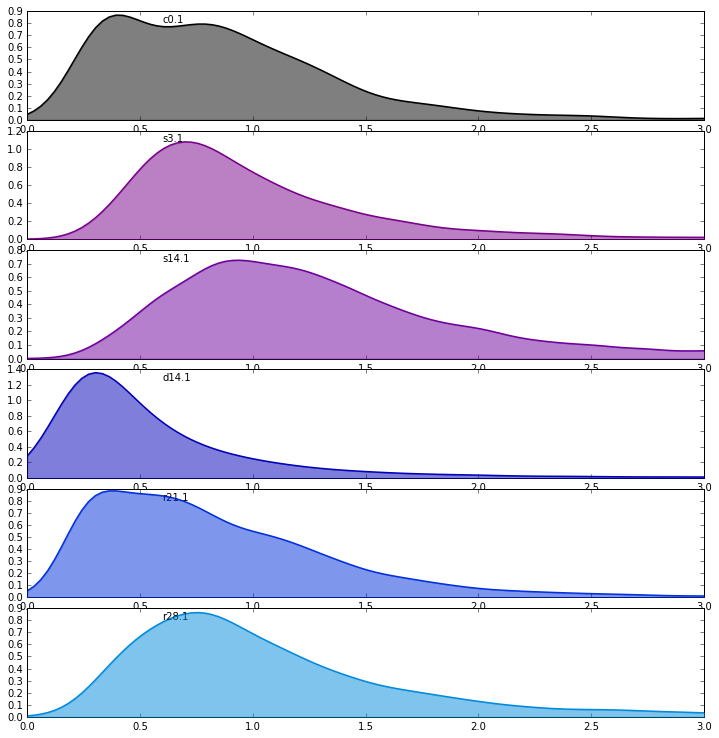

In [84]:
## Average over 3 replicates
fig, axes = plt.subplots(6,1) ; fig.set_size_inches(10, 10)
fig.subplots_adjust(top=.99, bottom=.01, left=.03, right=.97, wspace=.1, hspace=.1)
vals = np.append(RMI[0], RMI[1]); vals = np.append(vals, RMI[2]);
mean_control = vals.mean()
for i in range(6):
    vals = np.append(RMI[3*i], RMI[3*i+1]); vals = np.append(vals, RMI[3*i+2])/mean_control;
    density = gaussian_kde(vals)
    if i is 0:
        density.covariance_factor = lambda : .04 # set the covariance_factor, lower means more detail
    else:
        density.covariance_factor = lambda : .01 # set the covariance_factor, lower means more detail
    density._compute_covariance()
    #dx = np.linspace(0., np.percentile(vals,q=99),100)
    dx = np.linspace(0., 3., 100)
    dy = density(dx)
    axs = axes[i]
    axs.plot(dx, dy, linewidth=1.5, c=plt.cm.spectral(float(i)/18.))
    axs.fill_between(dx, dy, alpha=.5, zorder=5, antialiased=True, color=plt.cm.spectral(float(i)/18.))
    axs.text(0.2,0.9,pairfiles[3*i][0], fontsize=10, transform=axs.transAxes)
    axs.ticklabel_format(axis='x', style='sci', scilimits=(-3,3))